In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np 
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.interpolate import interp1d

- I want the ML to take as input 17 parameters corresponding to $[ \{ \alpha_i \}, \Omega_m, \Omega_m h^2 ]$ and to output the luminosity distance of the SN as a function of z, i.e. $d_L(z)$.
- In practice what I want is the ML to output an array of $d_L$, one of every bin in z. Therefore: $input = 1 \times 17$ and $output=1 \times N_{zbins}$.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.manual_seed(10)

# Load and normalize data

In [5]:
cosmo_data = h5py.File('/home/venus/cosmo_temp/uniform_cosmo_data_1PC.h5', 'r')
logdL_data = h5py.File('/home/venus/cosmo_temp/uniform_lodL_data_1PC.h5', 'r')

# cosmo_data = h5py.File('uniform_cosmo_data_2PC.h5', 'r')
# logdL_data = h5py.File('uniform_lodL_data_2PC.h5', 'r')

## Uniform sampling for the second PC != 0 only.
# cosmo_data = h5py.File('uniform_cosmo_data_secondPC.h5', 'r')
# logdL_data = h5py.File('uniform_lodL_data_secondPC.h5', 'r')

cosmo_data_tensor = torch.from_numpy(cosmo_data['data'][:]).float()
logdL_data_tensor = torch.from_numpy(logdL_data['processed_data'][:]).float()

# This dataset contains the cosmological parameters and the corresponding logdL values for each redshift bin 
dataset = TensorDataset(cosmo_data_tensor, logdL_data_tensor)

- The Dataset is an abstraction to be able to load and process each sample of your dataset lazily, while the DataLoader takes care of shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data, use pinned memory etc.
  
  https://discuss.pytorch.org/t/what-do-tensordataset-and-dataloader-do/107017

In [6]:
## Split the data into training, validation and testing sets
total_size = len(dataset)
train_size = int(0.6 * total_size)  
val_size = int(0.3 * total_size)    
test_size = total_size - train_size - val_size  

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

- Before I use the data, i need to normalize it.

In [7]:
# Extract training data from DataLoader object

train_loader1 = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

# I have set the batch_size in the previous command to be equal to the length of the training dataset -- so effectively I have only one batch containing the whole of the training set
# This for loop is supposed to extract the tensors from the trainloader1 so that I can calculated the mean and std
for data, labels in train_loader1:
    
    train_x_mean = data.mean(dim=0)
    train_x_std = data.std(dim=0)
    
    train_y_mean = labels.mean(dim=0)
    train_y_std = labels.std(dim=0)

# Define helper function that performs the data normalization
def helper_normalizer(data, mean, std):
    return (data - mean) / std
    
def normalize_data(dataset, mean_x, std_x, mean_y, std_y):
    loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    for data, labels in loader:
        norm_data_x = helper_normalizer(data, mean_x, std_x)
        norm_data_y = helper_normalizer(labels, mean_y, std_y)
    return norm_data_x, norm_data_y

# Normalize data tensors

norm_train_x, norm_train_y = normalize_data(train_dataset, train_x_mean, train_x_std, train_y_mean, train_y_std)
norm_val_x, norm_val_y = normalize_data(val_dataset, train_x_mean, train_x_std, train_y_mean, train_y_std)
norm_test_x, norm_test_y = normalize_data(test_dataset, train_x_mean, train_x_std, train_y_mean, train_y_std)
   
# Create new datasets with normalized data
train_dataset_normalized = TensorDataset(norm_train_x, norm_train_y)
val_dataset_normalized = TensorDataset(norm_val_x, norm_val_y)
test_dataset_normalized = TensorDataset(norm_test_x, norm_test_y)

# Create data loaders for each of the new normalized datasets
# Split in batches
batch_size = 32
train_loader = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_normalized, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=False)


    

# The NN

In [8]:
## Here I define an affine layer which will take care of the data normalization. 

class Affine(nn.Module):
    def __init__(self):
        super(Affine,self).__init__()
        self.gain = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.gain * x + self.bias
        

In [9]:
## Residual block - following the diagram in original ref: https://arxiv.org/pdf/1512.03385
## Each block will have two linear layers.
## The second activation is applied after I sum with the skip connection: ACT( F(x) + x )
class ResBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(ResBlock,self).__init__()
        if in_size != out_size:
            self.skip = nn.Linear(in_size, out_size, bias=False)
        else:
            self.skip = nn.Identity()
            
        self.linear1 = nn.Linear(in_size, out_size)
        self.linear2 = nn.Linear(out_size, out_size)

        self.norm1 = Affine()
        self.norm2 = Affine()

        # self.act1 = nn.ReLU()
        # self.act2 = nn.ReLU()
        self.act1 = nn.Tanh()
        self.act2 = nn.Tanh()
        
    def forward(self,x):
        xskip = self.skip(x)
        # x = self.act1(self.norm1(self.linear1(x)))
        # x = self.norm2(self.linear2(x))
        
        x = self.act1(self.linear1(self.norm1(x)))
        x = self.linear2(self.norm2(x))
        
        out = self.act2(x + xskip)
        return out
        
        

- Be careful with the definition of ModuleList. .modules() is a function defined under the class nn.Module, so I cannot reuse that name for a different method in my class definition.

In [10]:
class ResMLP(nn.Module):
    def __init__(self, input_dim, output_dim, block_nums):
        super(ResMLP,self).__init__()
        
        # Pytorch list that saves the different layers. These layers are not connected in a NN yet.
        # self.modules = nn.ModuleList()
        
        # Activation function to use
        # self.act = nn.ReLU()
        self.act = nn.Tanh()
        
        # self.block = ResBlock(input_dim, input_dim)
        # Write a for loop that controls how many ResBlocks I include in my full network
        # for i in range(block_nums):
        #     self.modules.append(self.block)
        
        self.mymodules = nn.ModuleList([ResBlock(input_dim, input_dim) for _ in range(block_nums)])   
        
        # The last layer I append in the nn.ModuleList is the fully connected linear layer (output layer of my NN)
        self.mymodules.append(nn.Linear(input_dim, output_dim))
        
    def forward(self,x):
        
        ## I need to add one layer here to embed my input vector to the bigger internal space 
        # Connect the different blocks in the NN
        for block in self.mymodules[:-1]:
            x = self.act(block(x))
            
        # Pass the output through the final fully connected linear layer
        out = self.mymodules[-1](x)
        
        return out                 


# Training

**Notes on training**
- Adam works significantly better than SGD.
- Using Adam and MSELoss works okay, but we still have y_pred much different than expected. 

In [11]:
## Training 
model = ResMLP(3,500,4)
model.to(device)
epochs = 30
train_losses = []
val_losses = []
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

- I want to use -log(likelihood) as my loss function. I need to define here the error -- same as the one in Mortonson et al 0810.1744

In [12]:
NSN = [0, 300, 35, 64, 95, 124, 150, 171, 183, 179, 170, 155, 142, 130, 119, 107, 94, 80, 0]
zSN = [0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.75]
SNpoints = list(zip(zSN, NSN))

# Create an interpolation function for the number of SN 

fNSN = interp1d(zSN, NSN, kind='linear', fill_value='extrapolate')

zBinsFisher = np.linspace(0.0334, 1.7, 500)

# This function returns the sigma^2 error defined in equation (A2)

def Sigma2SNFisher(i, Nz):        
    zzmin = 0.0334
    zzmax = 1.7
    zBinsFisher = np.linspace(zzmin, zzmax, Nz + 1)

    if i > len(zBinsFisher):
        raise ValueError("Index 'i' is out of range.")

    dz1 = 0.1
    dz2 = 0.07
    tmp = zBinsFisher[1] - zBinsFisher[0]

    z_i = zBinsFisher[i]  

    if z_i < 0.1:
        return dz2 / tmp * (0.15**2 / fNSN(z_i) + 0.02**2 * ((1 + z_i) / 2.7)**2)
    else:
        return dz1 / tmp * (0.15**2 / fNSN(z_i) + 0.02**2 * ((1 + z_i) / 2.7)**2)
        
# Test plot to make sure everything works so far

i_values = range(0, len(zBinsFisher))

# Compute Sigma2SNFisher for each i value (each redshift bin of interest)
sigma2_values = [Sigma2SNFisher(i,500) for i in i_values]
sigma2_values = np.array(sigma2_values)

sigma2_values_tensor = torch.from_numpy(sigma2_values).float().to(device)

# # Plot
# plt.figure(figsize=(4, 3))
# plt.plot(i_values, sigma2_values, linestyle='-', color='b')
# plt.xlabel('i')
# plt.ylabel('Sigma2SNFisher')
# plt.grid(True)
# plt.show()

In [13]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

2112

In [14]:
for data, labels in train_loader:
    data, labels = data.to(device), labels.to(device)
    outputs = model(data)
    print(outputs.shape)
    # print(criterion(outputs,labels))
    break

torch.Size([32, 500])


In [15]:
# ## Printing the initialization values of weights and biases
# def print_initial_parameters(model):
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(f"Parameter: {name}, Initial value: {param.data}")

# print_initial_parameters(model)


- Note: When I use the validation data during the training of my model, I want to set model.eval() such that the NN does not use this data to train the model. I also want to set torch.no_grad(), so that pytorch does not store the outputs of the activation functions -- therefore saving RAM.

In [16]:
train_y_std = train_y_std.to(device)
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)  
        ## I will use -log(Likelihood) as my loss function using as std the sigma that is given in 0810.1744 equation A2
        # loss1 =  0.5 * (labels - outputs) ** 2 / sigma2_values_tensor
        diff = (labels - outputs) * train_y_std
        loss1 = 0.5 * diff ** 2 / sigma2_values_tensor
        loss = torch.mean(loss1)   
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        # # Check gradients for NaNs
        # nan_found = False
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         if torch.isnan(param.grad).any():
        #             print(f"NaNs found in gradients of {name} during training")
        #             nan_found = True
        #             break
        
        # if nan_found:
        #     continue
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            ## I will use -log(Likelihood) as my loss function
            # loss1 =  0.5 * (labels - outputs) ** 2 / sigma2_values_tensor
            
            diff = (labels - outputs) * train_y_std
            loss1 = 0.5 * diff ** 2 / sigma2_values_tensor
            
            loss = torch.mean(loss1) 
            val_loss += loss.item() * data.size(0)
        val_loss /= len(val_dataset)
        val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

Epoch [10/30], Train Loss: 0.000015, Val Loss: 0.000018
Epoch [20/30], Train Loss: 0.000002, Val Loss: 0.000002
Epoch [30/30], Train Loss: 0.000001, Val Loss: 0.000001


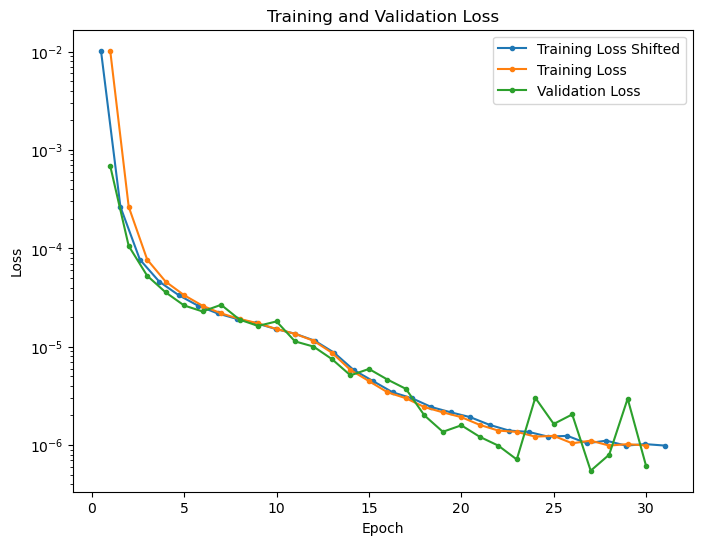

In [17]:
# Plot the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.5, len(train_losses) + 1, epochs), train_losses, marker='.', label='Training Loss Shifted')
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='.', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='.', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [18]:
model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        print(data.shape, labels.shape)
        print(labels.shape[0])
        break

torch.Size([32, 3]) torch.Size([32, 500])
32


# Testing

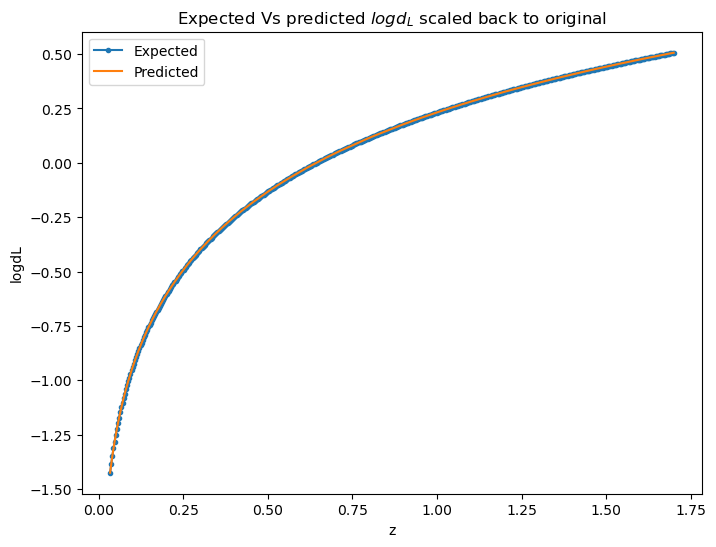

In [23]:
train_y_mean = train_y_mean.to(device)
train_y_std = train_y_std.to(device)
model.eval()
zBinsFisher = np.linspace(0.0334, 1.7, 500)

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        predictions = model(data)
        predictions_rescaled = predictions * train_y_std + train_y_mean
        labels_rescaled = labels * train_y_std + train_y_mean
        plt.figure(figsize=(8, 6))
        plt.plot(zBinsFisher, labels_rescaled[0,:].cpu().numpy(), marker='.', label='Expected')
        plt.plot(zBinsFisher, predictions_rescaled[0,:].cpu().numpy(),  label='Predicted')
        plt.xlabel('z')
        plt.ylabel('logdL')
        plt.title(r'Expected Vs predicted $logd_L$ scaled back to original')
        plt.legend()
        plt.show()
        break
        

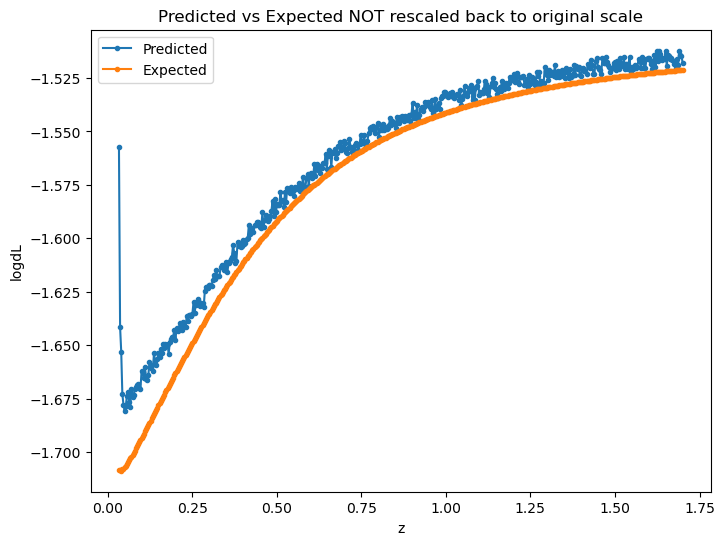

In [20]:
model.eval()
zBinsFisher = np.linspace(0.0334, 1.7, 500)
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        predictions = model(data)
        
        plt.figure(figsize=(8, 6))
        # for i in range(labels.shape[0]):
        #     plt.plot(zBinsFisher, predictions[0,:].cpu().numpy(), marker='.', label='Predicted %d' %i)
        plt.plot(zBinsFisher, predictions[0,:].cpu().numpy(), marker='.', label='Predicted')
        plt.plot(zBinsFisher, labels[0,:].cpu().numpy(), marker = '.', label='Expected')
        plt.xlabel('z')
        plt.ylabel('logdL')
        plt.title('Predicted vs Expected NOT rescaled back to original scale')
        plt.legend()
        plt.show()
        break

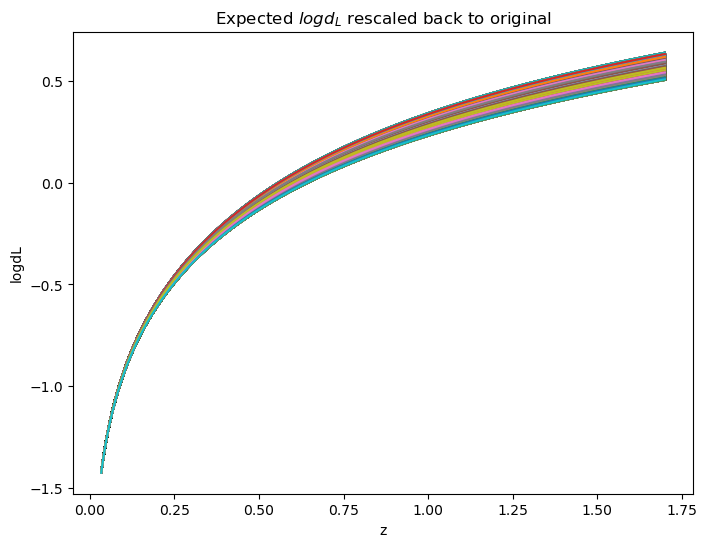

In [28]:
plt.figure(figsize=(8, 6))

with torch.no_grad():
    for data, labels in test_loader:
        labels = labels.to(device)
        labels_rescaled = labels * train_y_std + train_y_mean
        for i in range(labels.shape[0]):
            plt.plot(zBinsFisher, labels_rescaled[i,:].cpu().numpy(), label=f'Expected i = {i}')

plt.xlabel('z')
plt.ylabel('logdL')
plt.title(r'Expected $logd_L$ rescaled back to original')
#plt.legend()
plt.show()

- I will use the $\chi^2$  to check the goodness of fit for the outputs of my model. I will use the same error as my training loss ie equation A2 from 0810.1744.
  
  $\chi^2 = \sum \frac{\left( observed - expected \right)^2}{\sigma^2}$

In [24]:
model.eval()
chi_sq = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        pred = model(data)
        diff = (pred - labels) * train_y_std
        res = pow(diff, 2)
        chi_sq += torch.sum(torch.div(res, sigma2_values_tensor))
        #print(chi_sq.shape)
     
chi_sq = chi_sq.item()
print(f"Chi-squared statistic: {chi_sq:.2f}")
    


Chi-squared statistic: 3.20


In [ ]:
# model.eval()
# chi_sq = 0
# total_samples = 0

# with torch.no_grad():
#     for data, labels in test_loader:
#         data, labels = data.to(device), labels.to(device)
#         pred = model(data)
#         res = (pred - labels) ** 2
        
#         # Check if any expected value (label) is zero and skip if true
#         if torch.count_nonzero(labels) != labels.numel():
#             continue
        
#         chi_sq += torch.sum(res / labels)
#         total_samples += data.size(0)
     
# chi_sq = chi_sq.item()

# # Degrees of freedom: number of elements per sample - 1, multiplied by the number of valid samples
# num_elements_per_sample = labels.size(1)
# df = (num_elements_per_sample - 1) * total_samples

# # Calculate p-value
# p_value = 1 - chi2.cdf(chi_sq, df)

# print(f"Chi-squared statistic: {chi_sq:.4f}")
# print(f"P-value: {p_value:.4f}")

# # Interpretation
# if p_value > 0.05:
#     print("The model's fit is considered good (fail to reject the null hypothesis).")
# else:
#     print("The model's fit is considered poor (reject the null hypothesis).")
